In [1]:
import os
import glob
import pathlib
import polars as pl
import numpy as np
import matplotlib.pylab as plt

from matplotlib.axes import Axes
from typing import Any
from matplotlib_venn import venn3
from collections import OrderedDict

In [2]:
# If running with nbconvert 
WD = pathlib.Path(os.getcwd())
INTERACTIVE = WD.parts[-1] == "notebooks"
PATH_PREFIX = "../../" if INTERACTIVE else ""
OUTPUT_DIR = pathlib.Path(f"{PATH_PREFIX}results/nucflag_aligner_comparison").absolute()

ALIGNER_COLORS = ["#FFE6E6", "#E1AFD1", "#AD88C6"]
ALIGNER_PARAMS = OrderedDict({
    "pbmm2": "pbmm2\n(-log-level DEBUG\n--preset SUBREAD\n--min-length 5000 -j 24)",
    "winnowmap": "winnowmap\n(-a --eqx --cs\n-x map-pb\n-t 24 -I8g)",
    "minimap2": "minimap2\n(-a --eqx --cs\n-x map-hifi\n-t 24 -I8g)"
})

In [3]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Runtime Benchmarks

In [4]:
bmk_rows = []
for bmk in glob.glob(f"{PATH_PREFIX}benchmarks/nucflag_*/align_*"):
    path = pathlib.Path(bmk)
    run_type = path.parts[3] if INTERACTIVE else path.parts[1]

    with open(path, "rt") as fh:
        next(fh)
        for line in fh.readlines():
            wall_time, _, rss, *_, cpu_time = line.strip().split()
            bmk_rows.append((run_type, path.parts[-1], wall_time, cpu_time, rss))

df_bmk = (
    pl.DataFrame(
        bmk_rows,
        schema={
            "aligner": pl.String,
            "reads_file": pl.String,
            "wall_time": pl.Float32,
            "cpu_time": pl.Float32,
            "rss": pl.Float32
        }
    )
    .with_columns(
        pl.col("aligner").str.replace("nucflag_", "", literal=True).cast(pl.Enum(ALIGNER_PARAMS.keys())),
        pl.col("reads_file").str.extract(r"^align_(.*?)_hifi_reads_to_asm.tsv"),
        pl.col("cpu_time") / 3600,
        pl.col("wall_time") / 3600,
        pl.col("rss") / 1000
    )
)
df_bmk

aligner,reads_file,wall_time,cpu_time,rss
enum,str,f32,f32,f32
"""pbmm2""","""HG01884_HG01884.m54329U_210713…",1.251153,28.678995,90.396286
"""pbmm2""","""HG00609_m84081_231124_021221_s…",1.409482,32.875549,132.907135
"""pbmm2""","""HG01884_m84046_230707_192442_s…",0.418759,9.375425,105.31498
"""pbmm2""","""HG00423_m84081_231112_030942_s…",0.963935,19.23654,130.623184
"""pbmm2""","""HG00544_m84081_231119_032407_s…",1.344057,27.926069,130.272659
…,…,…,…,…
"""minimap2""","""HG01346_HG01346.m64076_210621_…",0.545695,11.189831,83.087303
"""minimap2""","""HG01099_m84081_231124_024327_s…",0.411005,7.472739,61.803291
"""minimap2""","""HG01884_HG01884.m54329U_210716…",0.531145,10.661254,80.56839


In [5]:
def draw_boxplots(df: pl.DataFrame, col: str, title: str, ylabel: str, *, sharey: bool = True, xlabels: dict[str, str] | None = None) -> tuple[plt.Figure, Any]:
    fig, axs = plt.subplots(1, 3, figsize=(8, 6), sharey=sharey)
    fig.suptitle(title)
    fig.supylabel(ylabel)
    fig.tight_layout()
    
    xlabels = xlabels if xlabels else {}

    for ax, (categ, df_categ), color in zip(axs, df.group_by(["aligner"], maintain_order=True), ALIGNER_COLORS):
        categ = categ[0]
        ax: Axes

        bplot = ax.boxplot(df_categ[col], manage_ticks=True, patch_artist=True)
        for patch in bplot["boxes"]:
            patch.set_facecolor(color)
        ax.set_xlabel(xlabels.get(categ, categ))
        ax.set_xticks([])

        quantiles = (df_categ[col].quantile(q) for q in [0.25, 0.5, 0.75])
        for q in quantiles:
            y = q
            ax.annotate(
                '%.2f' % q,
                (1, y),
                xytext=(1-0.1, y),
                textcoords='data',
                va='center',
                ha='right'
            )
    
    return fig, axs


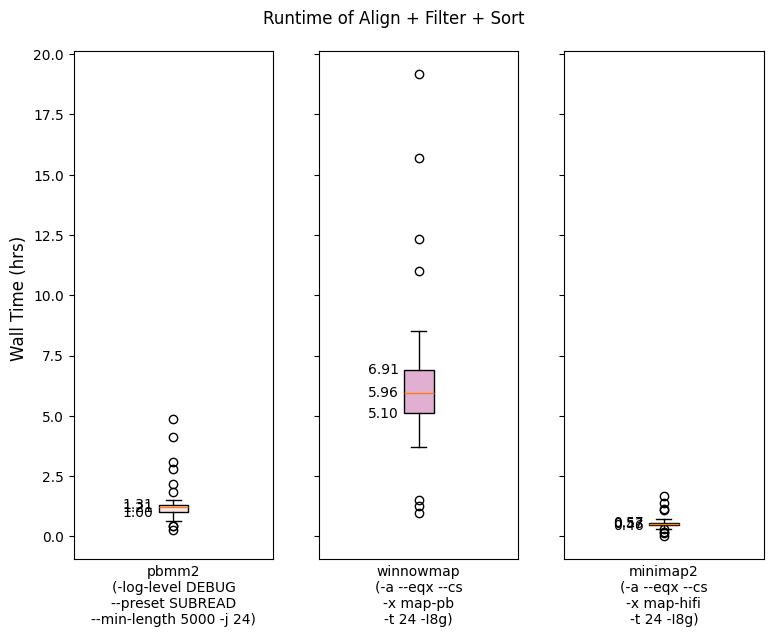

In [6]:
plt.close("all")
fig_wall_time, _ = draw_boxplots(df_bmk, "wall_time", "Runtime of Align + Filter + Sort", "Wall Time (hrs)", xlabels=ALIGNER_PARAMS)
fig_wall_time.savefig(OUTPUT_DIR.joinpath("wall_time.png"))
fig_wall_time.show()

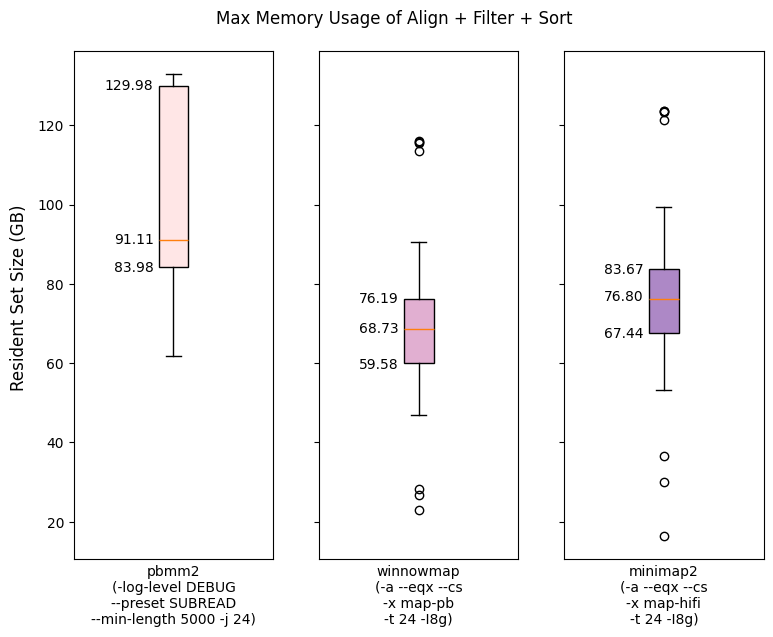

In [7]:
plt.close("all")
fig_memory, _ = draw_boxplots(df_bmk, "rss", "Max Memory Usage of Align + Filter + Sort", "Resident Set Size (GB)", xlabels=ALIGNER_PARAMS)
fig_memory.savefig(OUTPUT_DIR.joinpath("memory_usage.png"))
fig_memory.show()

# Number of Centromeres Correct

In [8]:
df_all_status_long = pl.concat(
    pl.read_csv(
        f"{PATH_PREFIX}results/nucflag_{aligner_name}/*_cen_status.bed",
        separator="\t",
        has_header=False,
        new_columns=["ctg", "start", "stop", "status"],
        glob=True
    )
    .with_columns(
        aligner=pl.lit(aligner_name),
        chrom=pl.col("ctg").str.extract(r"_(rc-)*(chr\w*?)_", group_index=2),
        sample=pl.col("ctg").str.extract(r"(\w*?)_"),
    )
    .with_columns(pl.col("aligner").cast(pl.Enum(ALIGNER_PARAMS.keys())))
    for aligner_name in ALIGNER_PARAMS.keys()
)
df_all_status_long

ctg,start,stop,status,aligner,chrom,sample
str,i64,i64,str,enum,str,str
"""HG00423_chr11_mat-0000008""",49909771,55596070,"""good""","""pbmm2""","""chr11""","""HG00423"""
"""HG00423_chr11_pat-0000497""",49558777,58059626,"""misassembled""","""pbmm2""","""chr11""","""HG00423"""
"""HG00423_chr12_mat-0000022""",33925857,37861752,"""misassembled""","""pbmm2""","""chr12""","""HG00423"""
"""HG00423_chr12_pat-0000510""",33907076,38497051,"""misassembled""","""pbmm2""","""chr12""","""HG00423"""
"""HG00423_chr16_mat-0000018""",34528119,37281696,"""good""","""pbmm2""","""chr16""","""HG00423"""
…,…,…,…,…,…,…
"""HG01884_rc-chr4_mat-0000012""",48980011,53893076,"""misassembled""","""minimap2""","""chr4""","""HG01884"""
"""HG01884_rc-chr4_pat-0000348""",49080813,53341862,"""misassembled""","""minimap2""","""chr4""","""HG01884"""
"""HG01884_rc-chr5_pat-0000363""",45847821,53002620,"""misassembled""","""minimap2""","""chr5""","""HG01884"""


In [9]:
df_all_status_wide = df_all_status_long.pivot(index=["ctg", "start", "stop", "chrom", "sample"], columns="aligner", values="status")
df_all_status_wide

ctg,start,stop,chrom,sample,pbmm2,winnowmap,minimap2
str,i64,i64,str,str,str,str,str
"""HG00423_chr11_mat-0000008""",49909771,55596070,"""chr11""","""HG00423""","""good""","""good""","""good"""
"""HG00423_chr11_pat-0000497""",49558777,58059626,"""chr11""","""HG00423""","""misassembled""","""misassembled""","""misassembled"""
"""HG00423_chr12_mat-0000022""",33925857,37861752,"""chr12""","""HG00423""","""misassembled""","""misassembled""","""good"""
"""HG00423_chr12_pat-0000510""",33907076,38497051,"""chr12""","""HG00423""","""misassembled""","""misassembled""","""misassembled"""
"""HG00423_chr16_mat-0000018""",34528119,37281696,"""chr16""","""HG00423""","""good""","""good""","""good"""
…,…,…,…,…,…,…,…
"""HG01884_rc-chr4_mat-0000012""",48980011,53893076,"""chr4""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""
"""HG01884_rc-chr4_pat-0000348""",49080813,53341862,"""chr4""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""
"""HG01884_rc-chr5_pat-0000363""",45847821,53002620,"""chr5""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""


In [10]:
venn_cnts = dict(
    df_all_status_wide
    .select("pbmm2", "winnowmap", "minimap2")
    .with_columns(pl.all().replace({"good": 1, "misassembled": 0}))
    .select(comb=pl.col("pbmm2") + pl.col("winnowmap") + pl.col("minimap2"))
    .get_column("comb")
    .value_counts()
    .rows()
)
venn_cnts

{'100': 6,
 '011': 2,
 '001': 5,
 '110': 7,
 '101': 24,
 '111': 137,
 '010': 9,
 '000': 259}

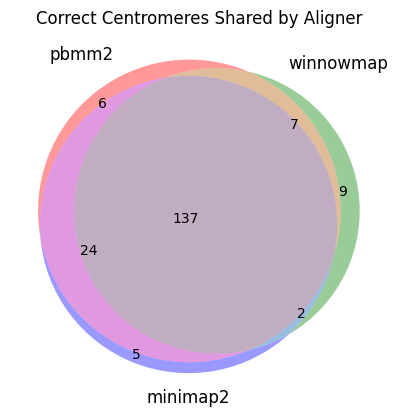

In [11]:
plt_venn = venn3(venn_cnts, set_labels=ALIGNER_PARAMS.keys())
ax = plt.gca()
_ = ax.set_title("Correct Centromeres Shared by Aligner")
plt.savefig(OUTPUT_DIR.joinpath("venn_shared_correct_cens.png"))

In [12]:
df_all_status_long_summarized = df_all_status_long.group_by("aligner").agg(pl.col("status").value_counts()).explode("status").unnest("status")
df_all_status_long_summarized

aligner,status,count
enum,str,u32
"""pbmm2""","""misassembled""",275
"""pbmm2""","""good""",174
"""winnowmap""","""misassembled""",294
"""winnowmap""","""good""",155
"""minimap2""","""good""",168
"""minimap2""","""misassembled""",281


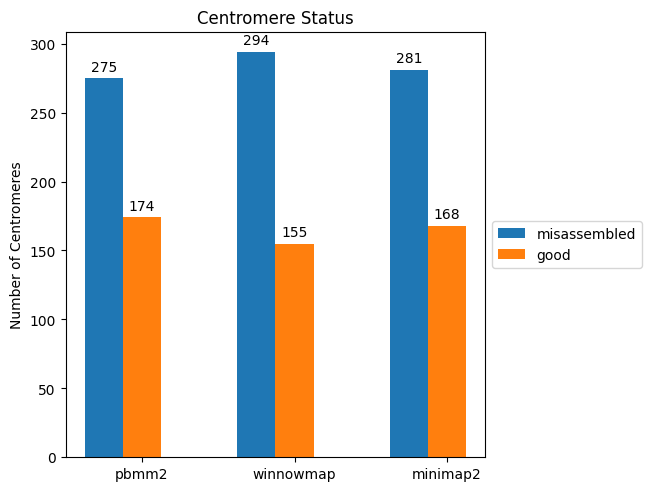

In [13]:
plt.close("all")
fig, ax = plt.subplots(layout='constrained')
ax: plt.Axes
width = 0.25

x = np.arange(len(ALIGNER_PARAMS.keys()))
for i, (status, df_status_grp) in enumerate(df_all_status_long_summarized.group_by(["status"], maintain_order=True)):
    status = status[0]
    offset = width * i
    rects = ax.bar(x + offset, df_status_grp["count"], width, label=status)
    ax.bar_label(rects, padding=3)

ax.set_ylabel('Number of Centromeres')
ax.set_title('Centromere Status')
ax.set_xticks(x + width, ALIGNER_PARAMS.keys())
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(OUTPUT_DIR.joinpath("cens_status.png"))

# Interesting differences
* HG00423_rc-chr15_pat-0000507:7304444-13860443.png
* HG00423_rc-chr10_mat-0000030:38571345-42825894
* HG00423_chr5_pat-0000495:45646463-53743265.png